# Random forest regressor from scratch

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import operator
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
import IPython, graphviz, re
from sklearn.metrics import r2_score

## Utils

In [3]:
# Proc from fast.ai to process dataframe, remove nas, drop y and convert x to numeric values
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if True:
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

# Draw tree (from fast.ai)
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

## Data

In [4]:
# This is from Kaggle bulldozers contest
df_raw = pd.read_csv('data/bulldozers/Train.csv', low_memory=False, parse_dates=["saledate"])
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Get x_train and y_train
x_train_orig = df_raw.drop('SalePrice', axis=1)
x_train = x_train_orig[['YearMade', 'MachineHoursCurrentMeter']]
y_train = df_raw['SalePrice'].values

# Log scale the y values
y_train = np.log(y_train)

# Print shapes
x_train.shape, y_train.shape

((401125, 2), (401125,))

In [6]:
# Visualize data
x_train.head(), y_train[:5]
print(x_train.columns, x_train.values)

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object') [[ 2004.    68.]
 [ 1996.  4640.]
 [ 2001.  2838.]
 ..., 
 [ 2005.    nan]
 [ 2005.    nan]
 [ 2005.    nan]]


In [7]:
# Replace nan
na_dict = {}
for n,c in x_train.items(): na_dict = fix_missing(x_train, c, n, na_dict)

# Get back x
x_train = x_train[['YearMade', 'MachineHoursCurrentMeter']]
x_train.head(), y_train[:5]
print(x_train.columns, x_train.values)
x_train.shape, y_train.shape

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object') [[ 2004.    68.]
 [ 1996.  4640.]
 [ 2001.  2838.]
 ..., 
 [ 2005.     0.]
 [ 2005.     0.]
 [ 2005.     0.]]


/home/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


((401125, 2), (401125,))

In [8]:
# Pick small subset for train, and small for validn
x_val_sample = x_train.iloc[1000:1001]
y_val_sample = y_train[1000:1001]
x_val = x_train.iloc[1000:1100]
y_val = y_train[1000:1100]
x_train = x_train.iloc[:1000]
y_train = y_train[:1000]
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1000, 2), (1000,), (100, 2), (100,))

## Random forest with decision tree model

### Class and functions

In [9]:
# Random forest class 
# Note: features are columns, samples are rows, x is independent variable, y is dependent variable
class Random_forest():
    
    # Create ensemble of trees
    def __init__(self, x, y, num_trees, sample_size=None, min_leaf_samples=5, max_depth=None):
        # If we want predictable results for testing, use here: np.random.seed(100)
        self.x = x ; self.y = y  
        if sample_size is None:
            self.sample_size = x.shape[0]  
        else:
            self.sample_size = sample_size  
        self.min_leaf_samples = min_leaf_samples
        self.max_depth = max_depth
        self.trees = [self.build_tree() for i in range(num_trees)]

    # Create one decision tree with sample_size rows chosen
    def build_tree(self):
        sample_idxs = np.random.permutation(len(self.y))[:self.sample_size]
        tree = Decision_tree(self.x.iloc[sample_idxs], 
                             self.y[sample_idxs], 
                             idxs = np.array(range(self.sample_size)), 
                             min_leaf_samples = self.min_leaf_samples, max_depth = self.max_depth, depth=None)
        return tree
    
    # Make mean prediction of all trees
    def predict(self, x):
        return np.mean([tree.predict(x) for tree in self.trees], axis=0)
    
# Decision tree class 
# Note: features are columns, samples are rows, x is independent variable, y is dependent variable
class Decision_tree():
    
    # Initialize
    def __init__(self, x, y, idxs = None, min_leaf_samples = 5, max_depth = None, depth=None):
        self.x = x ; self.y = y 
        self.sample_idxs = idxs 
        self.min_leaf_samples = min_leaf_samples
        self.num_samples = len(idxs)
        self.num_features = x.shape[1]
        self.pred_value = np.mean(y[idxs]) ; # Predictive value at this node of tree: using mean of all y
        self.score = float('inf') ; # Score used by decision tree to find the split
        self.best_feature_idx = None
        self.split_feature_name = None
        self.split_feature_value = None
        self.left_child_tree = None ; # Left tree is less than split value
        self.left_child_tree = None ; # Right tree is greater than split value
        self.max_depth = max_depth ;
        if depth is None: 
            self.depth = 0
        else:
            self.depth = depth
        self.find_best_split_feature()
        
    # Find the best feature to split
    def find_best_split_feature(self):
        # find best split value
        for feature_idx in range(self.num_features): 
            self.find_best_split_feature_value(feature_idx)
        # base case of recursion. Stop at leaf
        if self.is_leaf_node(): return        
        # best split feature and value are found ; recurse on the children here
        best_feature = self.x.values[self.sample_idxs, self.best_feature_idx]
        best_feature_val = self.split_feature_value
        left_split_idxs = np.nonzero(best_feature <= best_feature_val)[0] ; # first element of tuple gives indices
        right_split_idxs = np.nonzero(best_feature > best_feature_val)[0]
        self.left_child_tree = Decision_tree(self.x, self.y, 
                                             self.sample_idxs[left_split_idxs], 
                                             min_leaf_samples = self.min_leaf_samples,
                                             max_depth = self.max_depth, depth=self.depth + 1)
        self.right_child_tree = Decision_tree(self.x, self.y, 
                                              self.sample_idxs[right_split_idxs], 
                                              min_leaf_samples = self.min_leaf_samples,
                                              max_depth = self.max_depth, depth=self.depth + 1)

    # Find the best value to split in given feature: 
    # Using stddev here as score metric
    def find_best_split_feature_value(self, feature_idx):
        
        current_x = self.x.values[self.sample_idxs, feature_idx]
        current_y = self.y[self.sample_idxs]
        # find feature value with least stddev 
        # its computationally efficient to sort x by value once and find stddev of all possible value splits of x
        idxs_sorted = np.argsort(current_x)
        current_x_sorted = current_x[idxs_sorted] ;  current_y_sorted = current_y[idxs_sorted]
        left_split_cnt, left_split_sum, left_split_sumsquares = 0, 0.0, 0.0
        right_split_cnt, right_split_sum, right_split_sumsquares = self.num_samples, current_y_sorted.sum(), (current_y_sorted**2).sum()
        for sample_idx in range(self.num_samples - self.min_leaf_samples - 1):
            left_split_cnt += 1  ;  right_split_cnt -= 1  
            left_split_sum += current_y_sorted[sample_idx] ; left_split_sumsquares += current_y_sorted[sample_idx]**2           
            right_split_sum -= current_y_sorted[sample_idx] ; right_split_sumsquares -= current_y_sorted[sample_idx]**2
            # Count y for all equal values of x, 
            # Also dont go below min_leaf_samples on left split, right split taken care of for loop condition
            if (current_x_sorted[sample_idx] == current_x_sorted[sample_idx + 1]) or (sample_idx < self.min_leaf_samples):
                continue
            # Stddev till sample_idx idx of x
            left_split_stddev =  stddev(left_split_sum, left_split_sumsquares, left_split_cnt)
            right_split_stddev = stddev(right_split_sum, right_split_sumsquares, right_split_cnt)
            score = left_split_cnt*left_split_stddev + right_split_cnt*right_split_stddev
            if score < self.score:
                self.score = score ; self.best_feature_idx = feature_idx 
                self.split_feature_name = self.x.columns[feature_idx]
                self.split_feature_value = current_x_sorted[sample_idx]        
    
    # Is it a leaf node?
    def is_leaf_node(self): 
        #return self.score == float('inf') 
        return ((self.score == float('inf') 
                 or (self.num_samples < self.min_leaf_samples)
                 or (self.max_depth is not None and self.depth == self.max_depth)))
   
    # Print for python object
    def __repr__(self):
        msg = f'num_samples: {self.num_samples}; pred_value:{self.pred_value}'
        if not self.is_leaf_node():
            msg += f'; split_feature:{self.split_feature_name} ; split_value:{self.split_feature_value} ; score:{self.score}; '
        return msg   
  
    # Prediction for all x inputs
    def predict(self, samples_x):
        ypreds = np.array([self.predict_sample(sample_x) for sample_x in samples_x])
        return ypreds
    
    # Prediction per x input
    def predict_sample(self, sample_x):
        # base case
        if self.is_leaf_node(): return self.pred_value
        # recurse till leaf
        feature_val = sample_x[self.best_feature_idx]
        split_val = self.split_feature_value        
        if feature_val <= split_val:
            y_pred = self.left_child_tree.predict_sample(sample_x)
        else:
            y_pred = self.right_child_tree.predict_sample(sample_x)
        return y_pred       

    # Print tree
    def print_tree(self):
        tab = ""
        for _ in range(self.depth): tab += "\t"
        print(tab + str(self))
        if self.is_leaf_node(): return
        self.left_child_tree.print_tree() 
        self.right_child_tree.print_tree()
    

In [10]:
# Score functions:
def stddev(sum_samples, sum_squares_samples, num_samples):
    variance = (sum_squares_samples/num_samples) - (sum_samples/num_samples)**2
    #print("num_samples, sum_squares_samples, sum_samples, variance", num_samples, sum_squares_samples, sum_samples, variance)
    if variance < 0: variance = 0
    std_dev = math.sqrt(variance)
    return std_dev

### Compare model with 1 tree with sklearn model

In [11]:
# This random forest
my_rf = Random_forest(x_train, y_train, num_trees=1, min_leaf_samples=100, max_depth = 2)
my_rf.trees[0], my_rf.trees[0].left_child_tree, my_rf.trees[0].right_child_tree
my_rf.trees[0].print_tree()

num_samples: 1000; pred_value:10.160352993311724; split_feature:MachineHoursCurrentMeter ; split_value:2178.0 ; score:672.0239238186291; 
	num_samples: 470; pred_value:9.900122245394034; split_feature:YearMade ; split_value:2003.0 ; score:299.865909637946; 
		num_samples: 303; pred_value:9.754944365218092
		num_samples: 167; pred_value:10.163528818407867
	num_samples: 530; pred_value:10.391123656559486; split_feature:YearMade ; split_value:1997.0 ; score:349.1370243458754; 
		num_samples: 204; pred_value:10.200598892478142
		num_samples: 326; pred_value:10.510347742058242


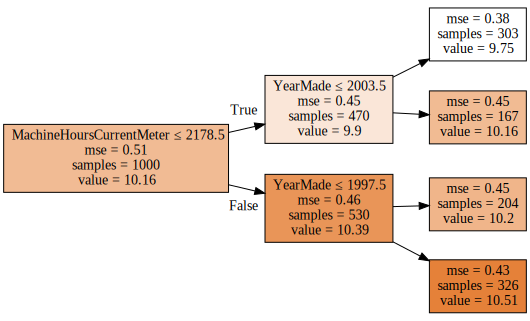

In [12]:
# Sklearn random forest for comparison
sklearn_rf = RandomForestRegressor(n_estimators=1, max_depth=2, min_samples_leaf= 100, bootstrap=False)
sklearn_rf.fit(x_train, y_train)
draw_tree(sklearn_rf.estimators_[0], x_train, precision=2)

#### Prediction for 1 sample

In [13]:
# Make example prediction with this model:
cols = ['YearMade', 'MachineHoursCurrentMeter']
preds = my_rf.trees[0].predict(x_val_sample[cols].values)
preds

array([ 10.20059889])

In [14]:
# Make example prediction with sklearn model:
sklearn_rf.predict(x_val_sample)

array([ 10.20059889])

### Compare model with >1 trees with sklearn model
 They are expected to be different since randomness is different for 2 approaches.
 - sklearn model uses all samples with bootstrapping
 - The model built here uses subsampling to create randomness. (Easy to add bootstrapping if needed)

In [15]:
# This random forest
my_rf = Random_forest(x_train, y_train, num_trees=2, sample_size = 500, min_leaf_samples=100, max_depth = 2)
my_rf.trees[0].print_tree()
my_rf.trees[1].print_tree()

num_samples: 500; pred_value:10.188816645493953; split_feature:MachineHoursCurrentMeter ; split_value:2895.0 ; score:341.87466953644105; 
	num_samples: 270; pred_value:9.961048622339483; split_feature:MachineHoursCurrentMeter ; split_value:1380.0 ; score:180.89875253344553; 
		num_samples: 168; pred_value:9.870532437967945
		num_samples: 102; pred_value:10.11013410248084
	num_samples: 230; pred_value:10.456196498762242; split_feature:YearMade ; split_value:1997.0 ; score:153.06420698788946; 
		num_samples: 105; pred_value:10.269387976095055
		num_samples: 125; pred_value:10.613115657802675
num_samples: 500; pred_value:10.14593111231774; split_feature:MachineHoursCurrentMeter ; split_value:2151.0 ; score:338.71650497644873; 
	num_samples: 231; pred_value:9.853723853234072; split_feature:YearMade ; split_value:2001.0 ; score:143.15812990359294; 
		num_samples: 128; pred_value:9.709363971821459
		num_samples: 103; pred_value:10.033122540814801
	num_samples: 269; pred_value:10.396860022534

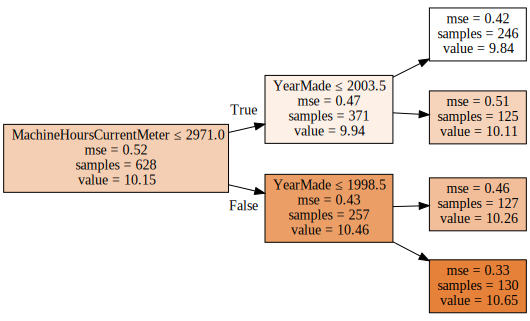

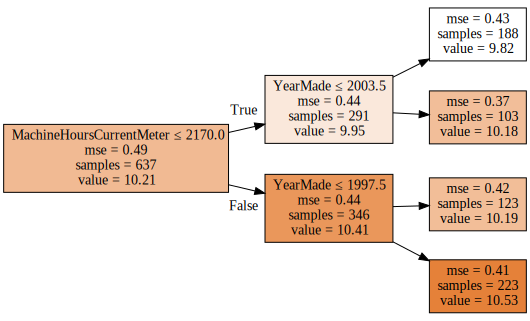

In [16]:
# Sklearn random forest for comparison
sklearn_rf = RandomForestRegressor(n_estimators=2, max_depth=2, min_samples_leaf= 100, bootstrap=True)
sklearn_rf.fit(x_train, y_train)
draw_tree(sklearn_rf.estimators_[0], x_train, precision=2)
draw_tree(sklearn_rf.estimators_[1], x_train, precision=2)

#### Prediction for 1 validation sample, and validation set

In [17]:
# Make example prediction with this model:
cols = ['YearMade', 'MachineHoursCurrentMeter']
preds = my_rf.predict(x_val_sample[cols].values)
preds

array([ 10.23032583])

In [18]:
# Make example prediction with sklearn model:
sklearn_rf.predict(x_val_sample)

array([ 10.22220924])

In [19]:
# Make validation set prediction with this model:
preds = my_rf.predict(x_val[cols].values)
r2_score(preds, y_val)

-3.8813431688328457

In [20]:
# Make validation set prediction with sklearn model:
preds = sklearn_rf.predict(x_val[cols].values)
r2_score(preds, y_val)

-4.6766654262608736